Deep Learning
=============

Assignment 4
------------

Previously in `2_fullyconnected.ipynb` and `3_regularization.ipynb`, we trained fully connected networks to classify [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) characters.

The goal of this assignment is make the neural network convolutional.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

In [88]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [89]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
    dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)


Training set (200000, 28, 28, 1) (200000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


In [90]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally, so we'll limit its depth and number of fully connected nodes.

In [5]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(
        tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
    
    layer1_biases = tf.Variable(tf.zeros([depth]))
    
    layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
    
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
    
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    
    layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
    
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
    # Model.
    def model(data):
        conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        
        conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        return tf.matmul(hidden, layer4_weights) + layer4_biases
  
    # Training computation.
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [11]:
num_steps = 1001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 50 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(
            valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.016590
Minibatch accuracy: 6.2%
Validation accuracy: 12.3%
Minibatch loss at step 50: 2.093434
Minibatch accuracy: 37.5%
Validation accuracy: 29.3%
Minibatch loss at step 100: 0.778546
Minibatch accuracy: 68.8%
Validation accuracy: 72.6%
Minibatch loss at step 150: 0.825853
Minibatch accuracy: 75.0%
Validation accuracy: 75.5%
Minibatch loss at step 200: 0.578314
Minibatch accuracy: 75.0%
Validation accuracy: 76.9%
Minibatch loss at step 250: 1.983891
Minibatch accuracy: 43.8%
Validation accuracy: 77.4%
Minibatch loss at step 300: 0.641023
Minibatch accuracy: 75.0%
Validation accuracy: 77.7%
Minibatch loss at step 350: 0.631031
Minibatch accuracy: 81.2%
Validation accuracy: 80.5%
Minibatch loss at step 400: 0.657327
Minibatch accuracy: 75.0%
Validation accuracy: 79.6%
Minibatch loss at step 450: 0.609125
Minibatch accuracy: 75.0%
Validation accuracy: 80.6%
Minibatch loss at step 500: 1.003252
Minibatch accuracy: 68.8%
Validation accuracy: 79.4%
Mi

---
Problem 1
---------

The convolutional model above uses convolutions with stride 2 to reduce the dimensionality. Replace the strides by a max pooling operation (`nn.max_pool()`) of stride 2 and kernel size 2.

---

In [7]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(
        tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
    
    layer1_biases = tf.Variable(tf.zeros([depth]))
    
    layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
    
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
    
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    
    layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
    
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
    # Model.
    def model(data):
        conv_1 = tf.nn.conv2d(data, layer1_weights, strides=[1, 1, 1, 1], padding='SAME')        
        hidden_1 = tf.nn.relu(conv_1 + layer1_biases)       
        hidden_pool_1 = tf.nn.max_pool(hidden_1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        
        
        conv_2 = tf.nn.conv2d(hidden_pool_1, layer2_weights, strides=[1, 1, 1, 1], padding='SAME')
        hidden_2 = tf.nn.relu(conv_2 + layer2_biases)
        hidden_pool_2 = tf.nn.max_pool(hidden_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        
        shape = hidden_pool_2.get_shape().as_list()
        reshape = tf.reshape(hidden_pool_2, [shape[0], shape[1] * shape[2] * shape[3]])        
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        
        return tf.matmul(hidden, layer4_weights) + layer4_biases
  
    # Training computation.
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [8]:
num_steps = 1001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 50 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(
            valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.639110
Minibatch accuracy: 18.8%
Validation accuracy: 10.0%
Minibatch loss at step 50: 1.410002
Minibatch accuracy: 50.0%
Validation accuracy: 55.7%
Minibatch loss at step 100: 0.623331
Minibatch accuracy: 62.5%
Validation accuracy: 69.8%
Minibatch loss at step 150: 1.121894
Minibatch accuracy: 81.2%
Validation accuracy: 75.0%
Minibatch loss at step 200: 0.543618
Minibatch accuracy: 81.2%
Validation accuracy: 76.7%
Minibatch loss at step 250: 1.592382
Minibatch accuracy: 56.2%
Validation accuracy: 75.4%
Minibatch loss at step 300: 0.549727
Minibatch accuracy: 81.2%
Validation accuracy: 77.5%
Minibatch loss at step 350: 0.612501
Minibatch accuracy: 87.5%
Validation accuracy: 81.8%
Minibatch loss at step 400: 0.666634
Minibatch accuracy: 75.0%
Validation accuracy: 79.1%
Minibatch loss at step 450: 0.597969
Minibatch accuracy: 87.5%
Validation accuracy: 80.4%
Minibatch loss at step 500: 0.733961
Minibatch accuracy: 75.0%
Validation accuracy: 80.5%
M

---
Problem 2
---------

Try to get the best performance you can using a convolutional net. Look for example at the classic [LeNet5](http://yann.lecun.com/exdb/lenet/) architecture, adding Dropout, and/or adding learning rate decay.

---

In [79]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64
beta = 0.001

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(
        tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
    
    layer1_biases = tf.Variable(tf.zeros([depth]))
    
    layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
    
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
    
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    
    layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_hidden], stddev=0.1))
    
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    
    layer5_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
    
    layer5_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
    # Model.
    def model_train(data):
        conv_1 = tf.nn.conv2d(data, layer1_weights, strides=[1, 1, 1, 1], padding='SAME')        
        hidden_1 = tf.nn.relu(conv_1 + layer1_biases)       
        hidden_pool_1 = tf.nn.max_pool(hidden_1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')        
        
        conv_2 = tf.nn.conv2d(hidden_pool_1, layer2_weights, strides=[1, 1, 1, 1], padding='SAME')
        hidden_2 = tf.nn.relu(conv_2 + layer2_biases)
        hidden_pool_2 = tf.nn.max_pool(hidden_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        
        #fully connected
        shape = hidden_pool_2.get_shape().as_list()
        reshape = tf.reshape(hidden_pool_2, [shape[0], shape[1] * shape[2] * shape[3]])        
        
        probs = 0.5        
        hidden_connected1 = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        hidden_connected1 = tf.nn.dropout(hidden_connected1, probs)
        
        hidden_connected2 = tf.nn.relu(tf.matmul(hidden_connected1, layer4_weights) + layer4_biases)        
        hidden_connected2 = tf.nn.dropout(hidden_connected2, probs)
        
        return tf.matmul(hidden_connected2, layer5_weights) + layer5_biases
    
    def model(data):
        conv_1 = tf.nn.conv2d(data, layer1_weights, strides=[1, 1, 1, 1], padding='SAME')        
        hidden_1 = tf.nn.relu(conv_1 + layer1_biases)       
        hidden_pool_1 = tf.nn.max_pool(hidden_1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')        
        
        conv_2 = tf.nn.conv2d(hidden_pool_1, layer2_weights, strides=[1, 1, 1, 1], padding='SAME')
        hidden_2 = tf.nn.relu(conv_2 + layer2_biases)
        hidden_pool_2 = tf.nn.max_pool(hidden_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        
        #fully connected
        shape = hidden_pool_2.get_shape().as_list()
        reshape = tf.reshape(hidden_pool_2, [shape[0], shape[1] * shape[2] * shape[3]])        
        
        hidden_connected1 = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        
        hidden_connected2 = tf.nn.relu(tf.matmul(hidden_connected1, layer4_weights) + layer4_biases)        
        
        return tf.matmul(hidden_connected2, layer5_weights) + layer5_biases
  
    # Training computation.
    logits = model_train(tf_train_dataset)
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
    regularizer = tf.nn.l2_loss(layer1_weights) + tf.nn.l2_loss(layer2_weights) + \
                    tf.nn.l2_loss(layer3_weights) + tf.nn.l2_loss(layer4_weights)    
    loss = tf.reduce_mean(loss + beta*regularizer)
    
    starter_learning_rate = 0.05
    global_step = 0
    decay_step = 1000
    decay_rate = 0.96
    learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, decay_step, decay_rate)
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [92]:
num_steps = 3000
valid_accuracy_hist = []
loss_hist = []
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 50 == 0):
            loss_hist.append(l)
            valid_acc = accuracy(valid_prediction.eval(), valid_labels)
            valid_accuracy_hist.append(valid_acc)
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % valid_acc)
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 4.903383
Minibatch accuracy: 6.2%
Validation accuracy: 10.0%
Minibatch loss at step 50: 2.593474
Minibatch accuracy: 12.5%
Validation accuracy: 10.7%
Minibatch loss at step 100: 2.441138
Minibatch accuracy: 12.5%
Validation accuracy: 42.4%
Minibatch loss at step 150: 2.595049
Minibatch accuracy: 18.8%
Validation accuracy: 53.4%
Minibatch loss at step 200: 1.812039
Minibatch accuracy: 43.8%
Validation accuracy: 53.2%
Minibatch loss at step 250: 2.412487
Minibatch accuracy: 31.2%
Validation accuracy: 62.4%
Minibatch loss at step 300: 1.657374
Minibatch accuracy: 31.2%
Validation accuracy: 64.9%
Minibatch loss at step 350: 1.576993
Minibatch accuracy: 56.2%
Validation accuracy: 65.6%
Minibatch loss at step 400: 1.391132
Minibatch accuracy: 62.5%
Validation accuracy: 64.9%
Minibatch loss at step 450: 1.385933
Minibatch accuracy: 62.5%
Validation accuracy: 72.9%
Minibatch loss at step 500: 1.949494
Minibatch accuracy: 43.8%
Validation accuracy: 73.3%
Mi

In [74]:
import matplotlib.pyplot as plt

In [93]:
plt.plot(valid_accuracy_hist)
plt.show()

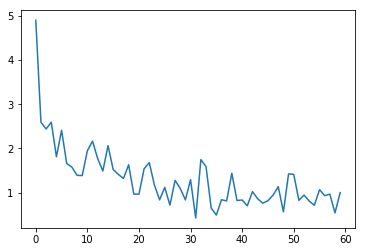

In [94]:
plt.plot(loss_hist)
plt.show()